# Práctica 4

Sebastián Rodríguez


Carnet: 20003076



In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import time
%reload_ext tensorboard

## Cargamos la data 

El dataset Fashion-MNIST cotiene 60,00 imagenes para el set de datos de entrenamiento y un set de datos de prueba de 10,000.

In [4]:
fashion_mnist = keras.datasets.fashion_mnist

In [5]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

## Imagenes
Las imagenes son Numpy Arrays de 28x28, los pixeles estan entre los valores de 0 a 255

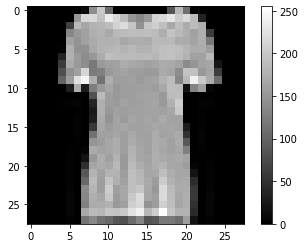

In [6]:
plt.imshow(train_images[10], cmap = 'gray')
plt.colorbar()

## Labels

In [7]:
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

| Label | Class       |
|-------|-------------|
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

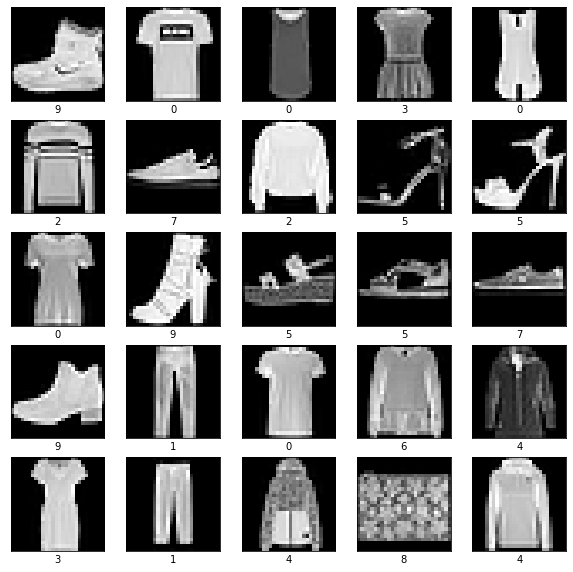

In [8]:
plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap='gray')
    plt.xlabel(train_labels[i])
plt.show()

# Tarea

Para esta tarea se deben utilizar únicamente 3 clases, se puede escoger cualquiera de las 10 disponibles en el data set, por lo que hay que filtrar las clases elegidas en los arreglos:
- train_images
- train_labels
- test_images
- test_labels

El objetivo de la tarea es comparar la diferencia al aplicar feature scale/normalization y las features sin ninguna transformación y comparar el efecto de el scaling/normalización sobre el entrenamiento con regresión logística.
- Se debe crear un diccionario con el valor numérico de las labels y el texto correspondiente para poder relacionar el valor numérico con el valor descriptivo/textual.
- Aplicar regresión logística con entropía cruzada como función de costo, crear una función que recibe de entrada un tensor x y predice la clase(utilizar el diccionario para mostrar el texto perteneciente al label).
- Adicional a el costo(por entropía cruzada) en el grafo se debe agregar un nodo que calcule el acurracy(comparando el valor real vs el estimado por el modelo).
- El accuracy y el costo deben ser agregados a tensorboard (agregar screenshots al notebook)
- Se debe agregar al notebook un screenshot del grafo/grafos de tensorboard, simplificando(usando names y name_scope como visto en clase).
- Todo lo anterior se debe hacer tanto para datos crudos, como para datos transformados con (normalización y escalado)
- Basado en los ejemplos de visualización de imagenes en el notebook ,crear una función que reciba de entrada el tensor que representa a una imagen, grafique esta imagen poniendo como título el nombre de la prenda con mayor probabilidad.
- Utilizar la función anterior para mostrar una muestra aleatoria de 5 imágenes(y la predicción probabilistica de la prenda)
- Comparar con tensorboard las curvas de aprendizaje del entrenamiento con datos crudos vs datos transformados, y los 2 grafos y concluir/opinar al respecto usando markdown(agregando screenshots)
- Utilizar mini batch gradient descent con batch size de 32

In [9]:
def Selec_Clase(train_labels, classes):
    selec1 = train_labels == classes[0]
    selec2 = train_labels == classes[1]
    selec3 = train_labels == classes[2]
    selec_tot = selec1 | selec2 | selec3
    
    Y_tr = train_labels[selec_tot]
    Y_tr[Y_tr == classes[0]] = 0
    Y_tr[Y_tr == classes[1]] = 1
    Y_tr[Y_tr == classes[2]] = 2   
    return selec_tot, Y_tr

def img_data(train_images, filtro):
    X_tr = np.reshape(train_images, (train_images.shape[0], 28*28))
    return X_tr[filtro]



In [10]:
ll_etiq, Y_tr = Selec_Clase(train_labels, [0, 1, 7])
X_tr = img_data(train_images, ll_etiq)

In [11]:
N, K = X_tr.shape
X_tr = np.column_stack((np.ones(N), X_tr))

In [12]:
dicClases = {0 : "T-shirt/top", 1 : "Trouser", 2 : "Sneaker"}

In [37]:
tf.reset_default_graph()
g = tf.Graph()
with g.as_default():
    X = tf.placeholder(tf.float32, shape = (None, K+2), name = "X")
    Ylabels = tf.placeholder(tf.int32, name = "Ylabels")
    lr = tf.placeholder(tf.float32, name = "Learning_Rate")
    W = tf.Variable(tf.truncated_normal(shape = [K+1, 2]), name = "Pesos")
   
    with tf.name_scope("Logits"):
        Logits = tf.matmul(X, W, name = "Logits") 
        Ypred_Hat = tf.nn.softmax(Logits, name = "Ypred_Hat")

    with tf.name_scope("Funcion_de_Costo"):
        cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels = Ylabels, logits = Logits), name = "Costo")

    with tf.name_scope("GDO"):
        optimizer = tf.train.GradientDescentOptimizer(lr).minimize(cost) 
        
    with tf.name_scope("Accuracy"):
        correctPredictions = tf.equal(Ylabels, tf.argmax(Ypred_Hat, 1, output_type = tf.int32), name = "Prediccion_Correcta")
        accuracy = tf.reduce_mean(tf.cast(correctPredictions, tf.float32), name = "Accuracy")
        
    with tf.name_scope("Resumen"):
        Resumen_Costo = tf.summary.scalar(name='Costo', tensor = cost)
        Resumen_Accuracy = tf.summary.scalar(name='Accuracy', tensor = accuracy)
        summaries = tf.summary.merge_all()
    init = tf.global_variables_initializer()



In [38]:
def Cant_batch(x, batchSize, batch_total, batchNo):
    if batchNo < batch_total:
        return x[batchSize*batchNo:batchSize*(batchNo+(batchNo*K)]
    else:
        return x[batchSize*batch_total:]

In [39]:
logs_dir = r"C:\Users\Sebastián\Desktop\logs"

def Mod_Lineal_TR(x, y, training_epochs, tam_batch, learning_rate, imprimirCada, tag):
    batch_total = (x.shape[0] // tam_batch)
    start = time.time()
    with tf.Session(graph = g) as sess: 
        writer = tf.summary.FileWriter(logs_dir, sess.graph)
        sess.run(init) 
        for epoch in range(training_epochs): 
            for batch in range(batch_total):
                xbatch = Cant_batch(x, tam_batch, batch_total, batch)
                ybatch = Cant_batch(y, tam_batch, batch_total, batch)
                _, summ = sess.run([optimizer, summaries], 
                    feed_dict = {X : xbatch, Ylabels : ybatch, lr : learning_rate})

                writer.add_summary(summ, epoch*batch_total + batch + 1)

                if (batch + 1) % imprimirCada == 0: 
                    c = sess.run(cost, feed_dict = {X : xbatch, Ylabels : ybatch})
                    print("Epoch = %d,\tNo. Batch = %d,\tCosto: %0.4f" % (epoch, batch+1, c))

        writer.close()
        weights = sess.run(W)
    end = time.time()
    print("Tiempo transcurrido: %0.2f segundos. " % (end-start))
    return (weights)

In [40]:
def predecir(x, weights):
    logits = np.matmul(x, weights)
    y = np.argmax(logits)
    return dicClases[y]

In [41]:

F_th = Mod_Lineal_TR(X_tr, Y_tr, 2, 32, 0.01, imprimirCada=60, tag='crudos')


Epoch = 0,	No. Batch = 75,	Costo: 4.1429
Epoch = 0,	No. Batch = 150,	Costo: 0.0000
Epoch = 0,	No. Batch = 225,	Costo: 0.0000
Epoch = 0,	No. Batch = 300,	Costo: 0.0000
Epoch = 0,	No. Batch = 375,	Costo: 0.0000
Epoch = 0,	No. Batch = 450,	Costo: 0.0000
Epoch = 0,	No. Batch = 525,	Costo: 0.0010
Epoch = 1,	No. Batch = 75,	Costo: 0.4983
Epoch = 1,	No. Batch = 150,	Costo: 0.0000
Epoch = 1,	No. Batch = 225,	Costo: 0.0000
Epoch = 1,	No. Batch = 300,	Costo: 0.0000
Epoch = 1,	No. Batch = 375,	Costo: 0.0000
Epoch = 1,	No. Batch = 450,	Costo: 0.0000
Epoch = 1,	No. Batch = 525,	Costo: 0.0000
Tiempo transcurrido: 0.90 segundos. 


Imágenes:  [10305  3249  2593 12038  6967  1370  4403 15302  7254  5543]


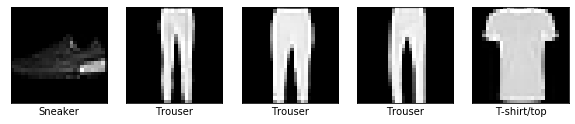

In [42]:
s = np.random.randint(0, N, 10)
random_x = X_tr[s]
print("Imágenes: ",s)

plt.figure(figsize = (10,10))
for i in range(5):
    plt.subplot(1, 5, i+3)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = random_x[i, 1:].reshape((15,15))
    plt.imshow(img, cmap = 'gray')
    plt.xlabel(predecir(random_x[i], F_th))


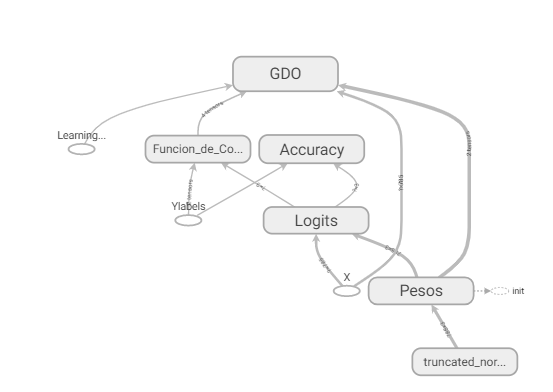

In [56]:
#%tensorboard --logdir="C:\Users\Sebastián\Desktop\logs_dir, sess.graph"
from IPython.display import Image
Image(filename='Grafo.png')

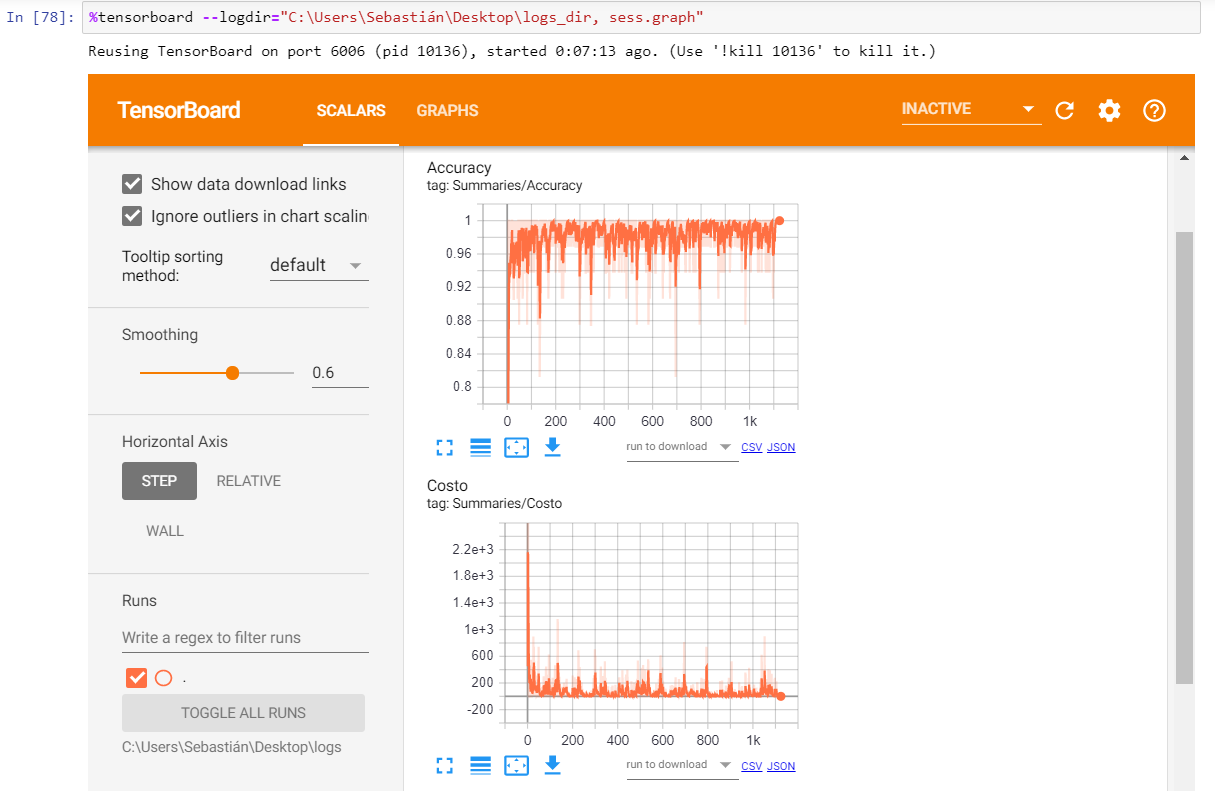

In [57]:
#%tensorboard --logdir="C:\Users\Sebastián\Desktop\logs_dir, sess.graph"

Image(filename='Img1.png')

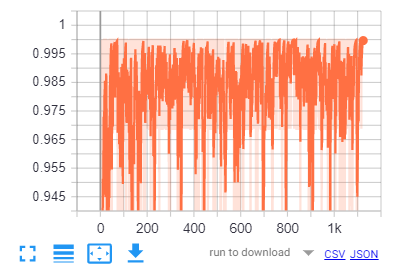

In [58]:
Image(filename='Accuracy.png')

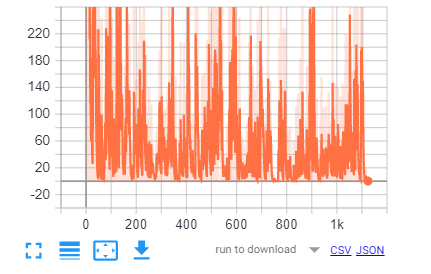

In [59]:
Image(filename='Costo.png')

In [60]:

Normalizar = X_tr.copy()
Normalizar[:, 1:] = Normalizar[:, 1:]
Normalizar

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [61]:

F_thRenorm = Mod_Lineal_TR(Normalizar, Y_tr, 2, 32, 0.01, imprimirCada = 60, tag = 'renorm')


Epoch = 0,	No. Batch = 75,	Costo: 0.9268
Epoch = 0,	No. Batch = 150,	Costo: 0.2091
Epoch = 0,	No. Batch = 225,	Costo: 0.3171
Epoch = 0,	No. Batch = 300,	Costo: 0.2253
Epoch = 0,	No. Batch = 375,	Costo: 0.0387
Epoch = 0,	No. Batch = 450,	Costo: 0.1841
Epoch = 0,	No. Batch = 525,	Costo: 0.0590
Epoch = 1,	No. Batch = 75,	Costo: 0.5896
Epoch = 1,	No. Batch = 150,	Costo: 0.0540
Epoch = 1,	No. Batch = 225,	Costo: 0.0736
Epoch = 1,	No. Batch = 300,	Costo: 0.1454
Epoch = 1,	No. Batch = 375,	Costo: 0.0130
Epoch = 1,	No. Batch = 450,	Costo: 0.1280
Epoch = 1,	No. Batch = 525,	Costo: 0.0608
Tiempo transcurrido: 0.88 segundos. 


Imágenes:  [ 2324  4363   743 10788  2306]


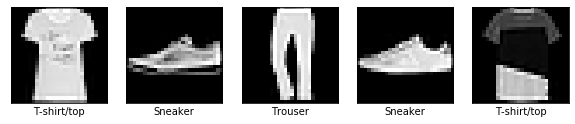

In [67]:
new_rand = np.random.randint(0, N, 5)
random_x = Normalizar[new_rand]
print("Imágenes: ",new_rand)


plt.figure(figsize = (10,10))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    img = random_x[i, 1:].reshape((15,15))
    plt.imshow(img, cmap = 'gray')
    plt.xlabel(predecir(random_x[i], F_thRenorm))


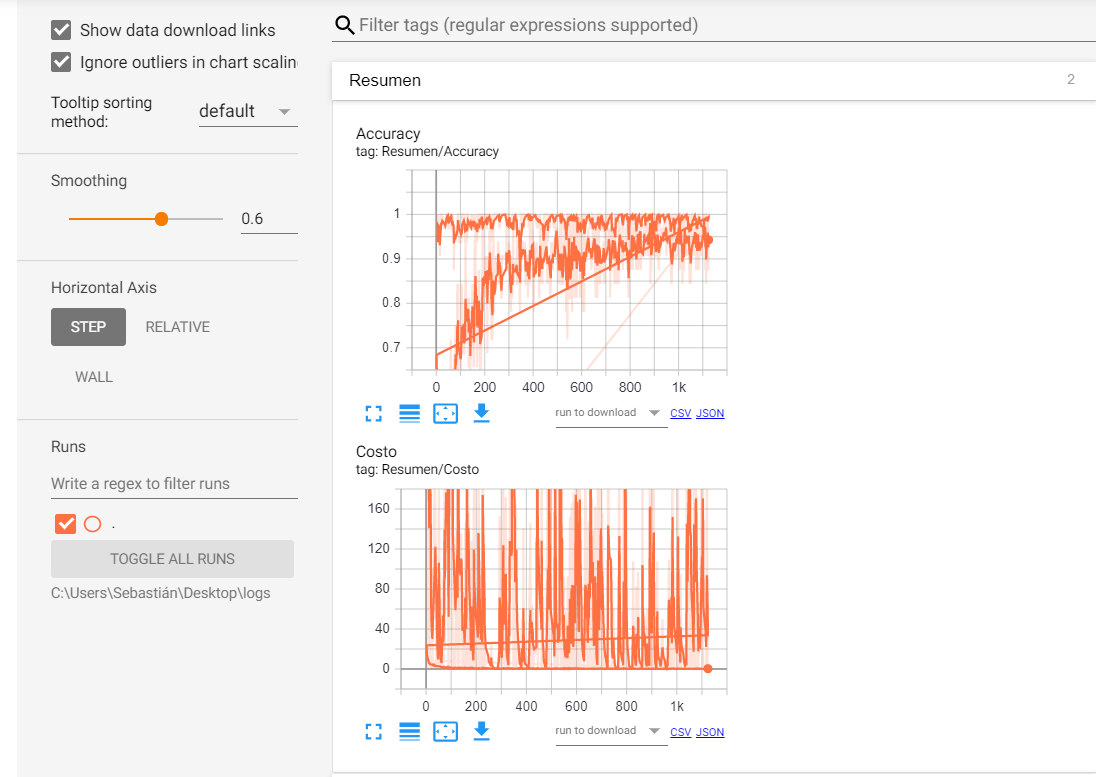

In [65]:
#%tensorboard --logdir="C:\Users\Sebastián\Desktop\logs_dir, sess.graph"
Image(filename='AcyCo.png')

In [51]:
ll_etiq, T_tstlb = Selec_Clase(test_labels, [0, 1, 7])
Img_N_x = img_data(test_images, ll_etiq)
Img_N_x = np.column_stack((np.ones(Img_N_x.shape[0]), Img_N_x))

In [52]:

def predictLabels(Xtest, F_th):
    u = tf.Graph()
    with u.as_default():
        X = tf.placeholder(tf.float32, shape = (None, K+1), name = "X")
        W = tf.placeholder(tf.float32, shape = (K+1, 3), name = "W")
        with tf.name_scope("Logits"):
            Logits = tf.matmul(X, W, name = "Logits") 
            Ypred_Hat = tf.argmax(tf.nn.softmax(Logits), 1, output_type = tf.int32, name = "Ypred_Hat")

    with tf.Session(graph = u) as sess:
        pred = sess.run(Ypred_Hat, feed_dict = {X : Xtest, W : F_th})
    
    return pred


In [53]:
def Acc_new(Xtest, YtrueLabels, F_th):
    Mod_new = predictLabels(Xtest, F_th)
    acc = np.mean(np.equal(Mod_new, YtrueLabels))
    print("Precision de: %0.2f%%" % (acc*100))
    return(acc)

In [54]:

Acc_new(Img_N_x, T_tstlb, F_th);


Precision de: 98.77%


In [55]:
Xtst_New = Img_N_x.copy()
Xtst_New[:, 1:] / 255.0 
Acc_new(Xtst_New, T_tstlb, F_thRenorm);


Precision de: 95.07%


# Conclusión

Se puede apreciar que el porcentaje de precisión aumenta con datos crudos en relación de los normalizados a pesar que la funciòn de costo converge a un mínimo de sin tanto ruido. 

Puede que no amerite para este set particular de datos, pero puede que se utilice más para datos con puntos minimos y máximos muy representativos. 